# Credit Card Default Prediction  

Using data of credit card clients (like previous months payments, marital status, education, gender etc), we will try to predict whether a particular client will default or not.   
  
We will use the following 4 different models for the same purpose : logistic regression, support vector machine, decision tree, and neural network

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Importing libraries for scaling and splitting dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error

#Importing our Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

## Exploring our data

In [2]:
data = pd.read_csv('UCI_Credit_Card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [4]:
# As we can see, there are no empty cells. So, we need not deal with them.

# Also, the "ID" column seems irrelevant, it is just the serial number of the client record and thus irrelevant for our model's
# training. So, we will drop it in the preprocessing stage.

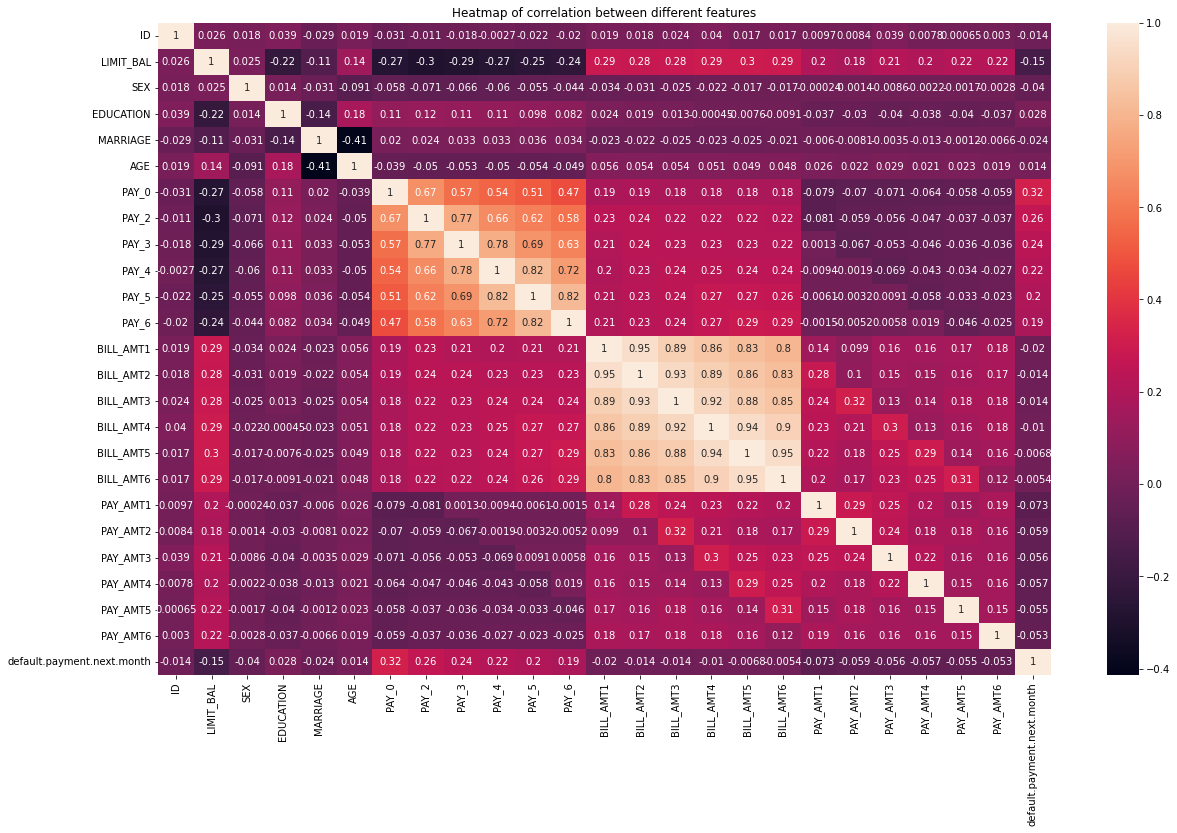

In [5]:
#Visualising feature correlation on a heatmap

correlation_map = data.corr()
plt.figure(figsize=(20,12))
sns.heatmap(correlation_map, annot=True, cmap='rocket')
plt.title("Heatmap of correlation between different features")
plt.show()

## Preprocessing Stage

In [6]:
def oneHotEncoder(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dum = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dum], axis=1)
        df = df.drop(column, axis=1)
    return df

In [7]:
def preprocessing_stage(df):
# Let us not diectly affect the original dataset. So, let's create a copy of the dataset and manipulate it only for further use. 
    df = df.copy()
    
    # Dropping irrelevant columns : "ID"
    df = df.drop('ID', axis=1)
    
    df = oneHotEncoder(
        df,
        {
            'EDUCATION': 'EDU',
            'MARRIAGE': 'MAR',
            'SEX': 'SEX'
        }
    )
    
    # Splitting dataframe df into input variables and output variables : x and y respectively
    y = df['default.payment.next.month'].copy()
    x = df.drop('default.payment.next.month', axis=1).copy()
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
    
    return x, y

In [8]:
x, y = preprocessing_stage(data)

In [9]:
x

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDU_3,EDU_4,EDU_5,EDU_6,MAR_0,MAR_1,MAR_2,MAR_3,SEX_1,SEX_2
0,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,-0.810161,0.810161
1,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,-0.810161,0.810161
2,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,-0.810161,0.810161
3,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,-0.810161,0.810161
4,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1.234323,-1.234323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,1.870379,2.018136,...,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1.234323,-1.234323
29996,-0.134759,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,0.253137,-0.672786,-0.665299,...,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,1.234323,-1.234323
29997,-1.059646,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,-0.647227,-0.643830,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,1.234323,-1.234323
29998,-0.674276,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,-0.616452,-0.717982,0.410269,...,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1.234323,-1.234323


In [10]:
y

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default.payment.next.month, Length: 30000, dtype: int64

## Training and Testing

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.5)

In [12]:
models = {
    LogisticRegression(): "Logistic Regression",
    SVC(): "Support Vector Machine",
    DecisionTreeClassifier(): "Decision Tree",
    MLPClassifier(): "Neural Network"
}

for model in models.keys():
    model.fit(x_train, y_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
for model, name in models.items():    
    y_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    
    print(name + ": {:.3f}%".format(model.score(x_test, y_test) *100))
    print(classification_report(y_pred, y_test))
    print('\nCorresponding confusion matrix : ')
    print(confusion_matrix(y_pred, y_test))
    print('\nTest Accuracy Score for the model: ', "{:.3f}%".format(accuracy_score(y_pred,y_test)*100))
    print('\nTrain Accuracy Score for the model: ', "{:.3f}%".format(accuracy_score(y_train_pred,y_train)*100))
    print('\n---------------------------------------------------\n\n')

Logistic Regression: 81.140%
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     13829
           1       0.25      0.70      0.37      1171

    accuracy                           0.81     15000
   macro avg       0.61      0.76      0.63     15000
weighted avg       0.91      0.81      0.85     15000


Corresponding confusion matrix : 
[[11348  2481]
 [  348   823]]

Test Accuracy Score for the model:  81.140%

Train Accuracy Score for the model:  81.080%

---------------------------------------------------


Support Vector Machine: 81.927%
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     13431
           1       0.33      0.69      0.44      1569

    accuracy                           0.82     15000
   macro avg       0.64      0.76      0.67     15000
weighted avg       0.89      0.82      0.85     15000


Corresponding confusion matrix : 
[[11208  2223]
 [  488  1081]]

Test A